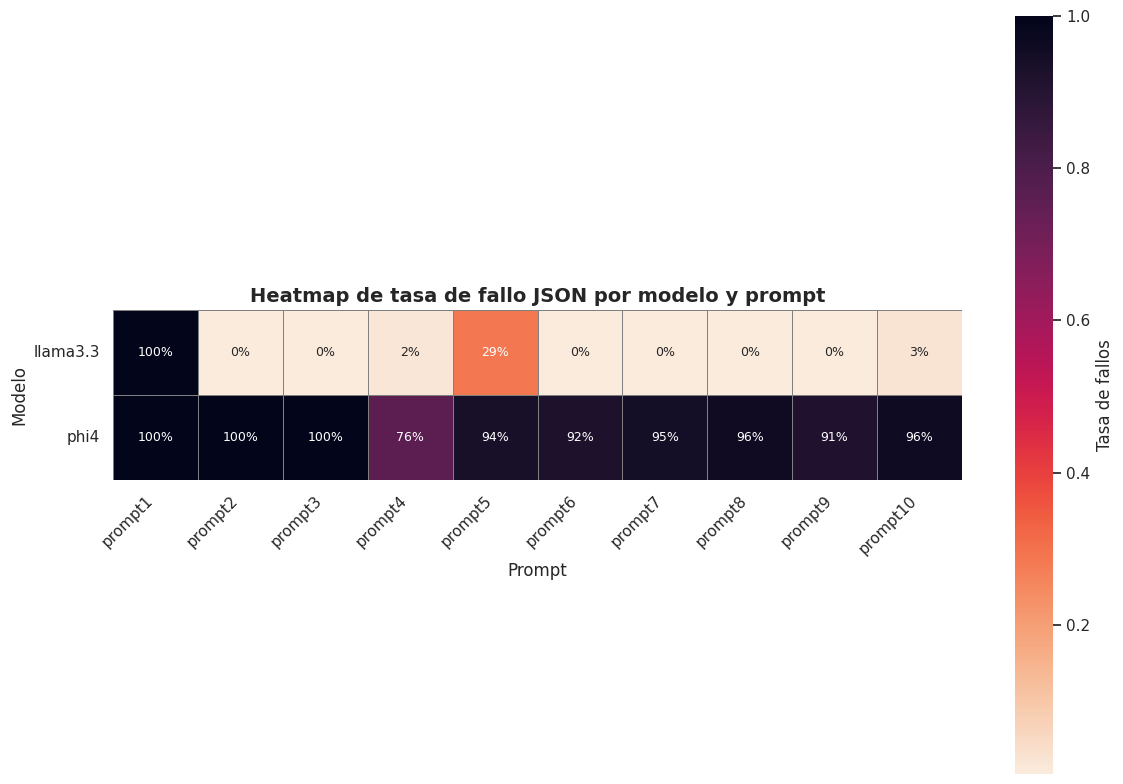

In [22]:
import re
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def normalizar_prompt(prompt):
    """Extrae solo el nombre del prompt final, por ejemplo 'prompt1'."""
    return prompt.strip().split("/")[-1]


def ordenar_prompts_numericamente(columnas):
    """Ordena los prompts por número (prompt1, prompt2, ..., prompt10)."""
    def extract_num(prompt):
        match = re.search(r'\d+', prompt)
        return int(match.group()) if match else float('inf')

    return sorted(columnas, key=extract_num)


def analizar_log(path_log):
    with open(path_log, "r", encoding="utf-8") as f:
        log = f.read()

    bloques = re.split(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3} - INFO - Procesando archivo:", log)
    if bloques[0].strip() == "":
        bloques = bloques[1:]

    errores_por_modelo_y_prompt = defaultdict(lambda: defaultdict(int))
    total_por_modelo_y_prompt = defaultdict(lambda: defaultdict(int))

    for bloque in bloques:
        modelo_match = re.search(r"Modelo:\s*(\S+)", bloque)
        modelo = modelo_match.group(1) if modelo_match else None
        if not modelo or modelo == "desconocido":
            continue  # Ignorar bloques sin modelo válido

        prompt_match = re.search(r"Directorio de salida:\s*(\S+)", bloque)
        prompt = normalizar_prompt(prompt_match.group(1)) if prompt_match else "prompt_desconocido"

        error_json = "Error parseando JSON" in bloque

        total_por_modelo_y_prompt[modelo][prompt] += 1
        if error_json:
            errores_por_modelo_y_prompt[modelo][prompt] += 1

    # Convertir a DataFrame
    data = []
    for modelo in total_por_modelo_y_prompt:
        for prompt in total_por_modelo_y_prompt[modelo]:
            total = total_por_modelo_y_prompt[modelo][prompt]
            errores = errores_por_modelo_y_prompt[modelo][prompt]
            tasa_fallo = errores / total if total else 0
            data.append((modelo, prompt, tasa_fallo))

    df = pd.DataFrame(data, columns=["Modelo", "Prompt", "Tasa de fallo"])
    pivot_df = df.pivot(index="Modelo", columns="Prompt", values="Tasa de fallo")

    # Ordenar columnas (prompts) numéricamente
    ordered_columns = ordenar_prompts_numericamente(pivot_df.columns)
    pivot_df = pivot_df[ordered_columns]

    return pivot_df


# Visualización
ruta_log = "logAnonymizer.log"
matriz_fallos = analizar_log(ruta_log)


plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Usamos rocket_r para que sea: blanco = bien, rojo oscuro = mal
ax = sns.heatmap(
    matriz_fallos,
    cmap="rocket_r",
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    square=True,
    annot=True,         # Muestra valores numéricos
    fmt=".0%",          # En formato porcentaje
    annot_kws={"fontsize": 9}
)

cbar = ax.collections[0].colorbar
cbar.set_label("Tasa de fallos", fontsize=12)

plt.title("Heatmap de tasa de fallo JSON por modelo y prompt", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
